In [1]:
# Initial imports.
import pandas as pd
import numpy as np
from path import Path
from ast import literal_eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
import csv
import random
import matplotlib.pyplot as plt

In [2]:
# Reading the clean data
file = 'fully_encoded_recipes_with_cuisine_from_SP.csv'
recipe_df = pd.read_csv(file, index_col=0)
recipe_df

,cuisine_SP,onion,garlic,vanilla,lemon,bell pepper,tomato,chocolate,mushrooms,italian cheese,...,harissa,sprouts,squash blossoms,grapefruit,tamarind pulp,savory,baharat,douchi,sucralose,jicama
recipe_code,,,,,,,,,,,,,,,,,,,,,
5,8,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,11,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,10,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,11,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9981,10,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9984,10,0,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def call_grid_search (X_raw, y_raw, random_st):
    
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state = random_st)
    rfc_model = RandomForestClassifier()
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    # Random search of parameters
    rf_random = RandomizedSearchCV(estimator = rfc_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                                   random_state=random_st, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, np.ravel(y_train))
    best_params = dict()
    best_params = rf_random.best_params_
    return best_params

In [4]:
def cross_validate(X_raw, y_raw, parameters, num_cv_runs):
    colors = []
    colors = ['black','silver','lightcoral','red','darkorange','gold','olivedrab','lawngreen','darkgreen','aquamarine','teal',
              'cyan','dodgerblue','violet','fuchsia']
    classes_list = [0,1]
    composite_fpr = []
    composite_tpr = []
    average_roc_auc = []
    roc_auc = dict()
    
    for i in range(1,num_cv_runs):
        X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw,random_state = 42)
        rf_model = RandomForestClassifier(n_estimators=parameters['n_estimators'],
                                          min_samples_split=parameters['min_samples_split'],
                                          min_samples_leaf=parameters['min_samples_leaf'],
                                          max_features=parameters['max_features'],
                                          max_depth=parameters['max_depth'],
                                          random_state = 42)
        rf_model.fit(X_train, np.ravel(y_train))
        y_score = rf_model.predict_proba(X_test)
#         y_test_bin = label_binarize(y_test, classes = classes_list)
#         n_classes = y_test_bin.shape[1]
#         print(y_score)
        fpr = dict()
        tpr = dict()
        local_roc_auc = []
        fpr[0], tpr[0], thresholds = roc_curve(y_test, y_score[:,1])
        local_roc_auc.append(roc_auc_score(y_test, y_score[:,1]))
        composite_fpr.append(fpr)
        composite_tpr.append(tpr)
#         print(composite_fpr)
# Plot out area under curve vs class number           
        
        roc_auc[i] = local_roc_auc  
        average_roc_auc.append
#         for item in roc_auc.values():
#             print(item)
#             plt.plot(classes_list, item, color=colors[index], lw=2)
# #             plt.plot(fpr[index], tpr[index], color=colors[index], lw=2,label=f'class: {index}')
# #             print('AUC for Class {}: {}'.format(index+1, roc_auc_score(fpr[index], tpr[index])))
#     plt.xlim([0.0, 15.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('class')
#     plt.ylabel('roc_auc')
#     plt.title('Area Under Receiver Operating Characteristic Curves')
#     plt.show()
# Plot out ROC curves

#     print(composite_fpr[0])

    for index in range(0, len(composite_fpr)):
       
#         print(composite_tpr[index])
#         print('***********************************')
#         print(composite_fpr[index])
#         print('++++++++++++++++++++++++++++++++++++')
        for i in range(0,len(composite_fpr[index])):
            plt.plot(composite_fpr[index][i],composite_tpr[index][i], color=colors[i], lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')
    plt.show()
    
#     average = []
#     for index in range(1, len(roc_auc)+1):
#         total = 0
#         for element in roc_auc[index]:
#             total = total + element
#         average.append(total/15)
#     counter = [x for x in range(len(average))]
#     plt.plot(counter, average)
    
    return roc_auc

In [5]:
encoding_key = pd.read_csv('cuisine_encoding_dict.csv', index_col=0)
encoding_key

,African,American,Asian,Creole,English,European,French,Greek,Indian,Irish,Italian,Mexican,Middle Eastern,Southern,Spanish
encoded,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14


## Data are processed to dataframes with and without response variables (cuisines) and the response variables are encoded to variables

In [6]:
french_df = recipe_df[recipe_df.cuisine_SP==6].copy()
non_french_df = recipe_df[recipe_df.cuisine_SP!=6]
non_french_df_indexes = pd.DataFrame(non_french_df.index.values, columns=['recipe_num'])
non_french_df_indexes

,recipe_num
0,5
1,10
2,16
3,17
4,20
...,...
2806,9978
2807,9981
2808,9984
2809,9988


In [7]:
index_for_balance = set()
while len(index_for_balance)<=len(french_df):
    index_for_balance.add(random.randint(0,2810))
index_for_balance = list(index_for_balance)
non_french_df_balance = non_french_df.iloc[index_for_balance]
non_french_df_balance
    

,cuisine_SP,onion,garlic,vanilla,lemon,bell pepper,tomato,chocolate,mushrooms,italian cheese,...,harissa,sprouts,squash blossoms,grapefruit,tamarind pulp,savory,baharat,douchi,sucralose,jicama
recipe_code,,,,,,,,,,,,,,,,,,,,,
7284,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,8,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1970,10,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
46,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3801,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,2,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3678,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5470,11,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
french_df_balanced = pd.concat([french_df, non_french_df_balance])

In [9]:
french_df_balanced

,cuisine_SP,onion,garlic,vanilla,lemon,bell pepper,tomato,chocolate,mushrooms,italian cheese,...,harissa,sprouts,squash blossoms,grapefruit,tamarind pulp,savory,baharat,douchi,sucralose,jicama
recipe_code,,,,,,,,,,,,,,,,,,,,,
85,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278,6,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
324,6,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
434,6,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
495,6,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,2,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3678,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5470,11,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
french_df_balanced['response'] = 0
french_df_balanced.response = french_df_balanced.response.mask(french_df_balanced.cuisine_SP==6, 1)
french_df_balanced.drop(columns='cuisine_SP', inplace=True)

In [11]:
#Define the features set
X = french_df_balanced.copy()
X = X.drop("response", axis=1)
X

,onion,garlic,vanilla,lemon,bell pepper,tomato,chocolate,mushrooms,italian cheese,parsley,...,harissa,sprouts,squash blossoms,grapefruit,tamarind pulp,savory,baharat,douchi,sucralose,jicama
recipe_code,,,,,,,,,,,,,,,,,,,,,
85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
324,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
434,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
495,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3678,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5470,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# define the target

y = french_df_balanced["response"]
y

recipe_code
85      1
278     1
324     1
434     1
495     1
       ..
1860    0
3678    0
5470    0
7263    0
7264    0
Name: response, Length: 283, dtype: int64

In [13]:
parameters_to_run = call_grid_search(X, y, 42)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


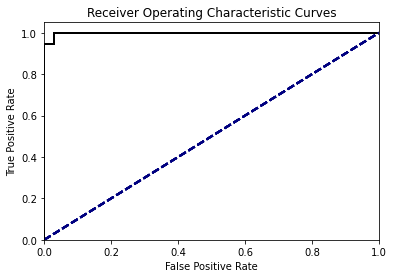

In [14]:
roc_auc_out = dict()
roc_auc_out = cross_validate(X, y, parameters_to_run, 10)

In [15]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [16]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78) 
rf_model = RandomForestClassifier(n_estimators=parameters_to_run['n_estimators'],
                                          min_samples_split=parameters_to_run['min_samples_split'],
                                          min_samples_leaf=parameters_to_run['min_samples_leaf'],
                                          max_features=parameters_to_run['max_features'],
                                          max_depth=parameters_to_run['max_depth'],
                                          random_state = 78)

In [17]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [18]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test)


In [19]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], 
    columns=["Predicted 0", "Predicted 1"])
    
cm_df

,Predicted 0,Predicted 1
Actual 0,28,8
Actual 1,0,35


In [20]:
importance = rf_model.feature_importances_

In [21]:
importance_df = pd.DataFrame(importance, index=X.columns.values, columns=['feature_importance'])
importance_df = importance_df.sort_values('feature_importance', ascending=False)

In [22]:
importance_df.iloc[0:10,:]

,feature_importance
thyme,0.063888
banana,0.054108
lemon,0.052798
wine,0.035193
rice,0.033795
garlic,0.030272
berries,0.029089
onion,0.025968
lime,0.025635
fresh pepper,0.025559
